In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
from google.colab import files
uploaded=files.upload()

Saving kaggle.json to kaggle (3).json


In [3]:
!pwd

/content


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR']="/content"

In [5]:
!kaggle competitions download -c titanic
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
 99% 729M/736M [00:05<00:00, 153MB/s]
100% 736M/736M [00:05<00:00, 149MB/s]


In [6]:
!unzip /content/eye-diseases-classification.zip

Archive:  /content/eye-diseases-classification.zip
  inflating: dataset/cataract/0_left.jpg  
  inflating: dataset/cataract/103_left.jpg  
  inflating: dataset/cataract/1062_right.jpg  
  inflating: dataset/cataract/1083_left.jpg  
  inflating: dataset/cataract/1084_right.jpg  
  inflating: dataset/cataract/1102_left.jpg  
  inflating: dataset/cataract/1102_right.jpg  
  inflating: dataset/cataract/1115_left.jpg  
  inflating: dataset/cataract/1126_right.jpg  
  inflating: dataset/cataract/112_right.jpg  
  inflating: dataset/cataract/1144_left.jpg  
  inflating: dataset/cataract/1144_right.jpg  
  inflating: dataset/cataract/1164_left.jpg  
  inflating: dataset/cataract/1167_right.jpg  
  inflating: dataset/cataract/119_left.jpg  
  inflating: dataset/cataract/1285_left.jpg  
  inflating: dataset/cataract/1415_left.jpg  
  inflating: dataset/cataract/1415_right.jpg  
  inflating: dataset/cataract/1435_left.jpg  
  inflating: dataset/cataract/1444_left.jpg  
  inflating: dataset/catara

In [7]:
IMAGE_SIZE = 256
BATCH_SIZE = 128
CHANNELS = 3
EPOCHS = 128

In [8]:
dataset= tf.keras.preprocessing.image_dataset_from_directory("/content/dataset",shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size= BATCH_SIZE)

Found 4217 files belonging to 4 classes.


In [9]:
class_names=dataset.class_names
class_names

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [10]:
for image_batch, labels_batch in dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.numpy())

(128, 256, 256, 3)
[2 1 2 3 0 0 0 3 1 3 2 0 1 1 0 2 3 0 3 0 3 2 0 0 1 0 2 1 0 1 3 0 1 0 0 0 3
 1 3 3 1 1 1 3 2 2 3 2 3 3 2 3 0 1 0 3 2 0 1 1 0 2 3 3 2 0 1 0 3 0 2 1 2 0
 1 1 3 2 3 3 1 1 2 3 0 2 1 3 3 1 2 2 3 0 0 1 3 1 2 3 3 3 1 2 3 1 0 3 0 1 2
 2 1 3 3 3 2 2 3 0 3 0 1 2 0 2 2 3]


In [11]:
def get_dataset_partitions_tf(ds, train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  assert(train_split+test_split+val_split)==1
  ds_size = len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=6)
  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)
  train_ds=ds.take(train_size)
  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [13]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch[0].numpy()/255)

[[[0.         0.00392157 0.        ]
  [0.         0.00392157 0.        ]
  [0.         0.00784314 0.00392157]
  ...
  [0.00196078 0.00196078 0.00196078]
  [0.00392157 0.00392157 0.00392157]
  [0.         0.00784314 0.00392157]]

 [[0.         0.00392157 0.        ]
  [0.         0.00392157 0.        ]
  [0.         0.00490196 0.00098039]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.00392157 0.00392157 0.00392157]]

 [[0.         0.00392157 0.        ]
  [0.         0.00490196 0.00098039]
  [0.         0.00392157 0.        ]
  ...
  [0.         0.00392157 0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.00588235 0.00196078]
  [0.         0.00588235 0.00196078]
  [0.         0.00392157 0.        ]
  ...
  [0.         0.00392157 0.        ]
  [0.         0.00392157 0.        ]
  [0.         0.00392157 0.        ]]

 [[0.         0.00784314 0.00392157]
  [0.         0.00784314 0.00392157]


In [15]:
resizing_and_rescaling=tf.keras.Sequential([layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE), 
    layers.experimental.preprocessing.Rescaling(1.0/255)])

In [16]:
data_augmentation=tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)])

In [17]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=5
model=models.Sequential([
    resizing_and_rescaling,
    data_augmentation,
    layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (128, 256, 256, 3)        0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/128


26/26 [==============================] - 89s 2s/step - loss: 1.2977 - accuracy: 0.3776 - val_loss: 1.1400 - val_accuracy: 0.4896
Epoch 2/128
26/26 [==============================] - 22s 861ms/step - loss: 0.9754 - accuracy: 0.5586 - val_loss: 0.9759 - val_accuracy: 0.5599
Epoch 3/128
26/26 [==============================] - 23s 874ms/step - loss: 0.8671 - accuracy: 0.6076 - val_loss: 0.8848 - val_accuracy: 0.6120
Epoch 4/128
26/26 [==============================] - 22s 827ms/step - loss: 0.8034 - accuracy: 0.6354 - val_loss: 0.8282 - val_accuracy: 0.6328
Epoch 5/128
26/26 [==============================] - 23s 890ms/step - loss: 0.7643 - accuracy: 0.6706 - val_loss: 0.9291 - val_accuracy: 0.5651
Epoch 6/128
26/26 [==============================] - 22s 857ms/step - loss: 0.7316 - accuracy: 0.6760 - val_loss: 0.7311 - val_accuracy: 0.6667
Epoch 7/128
26/26 [==============================] - 22s 866ms/step - loss: 0.6677 - accuracy: 0.7103 - val_loss: 0.6746 - val_accuracy: 0.7240
Epoch 8

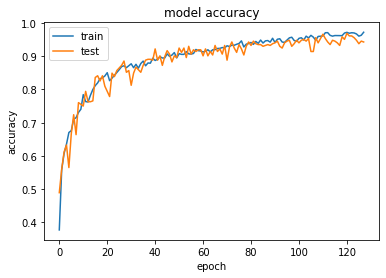

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

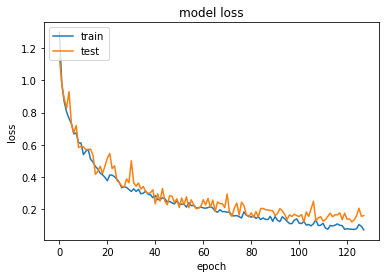

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

First image to predict
Actual label: normal
4/4 [==============================] - 1s 23ms/step
Predicted Label: normal


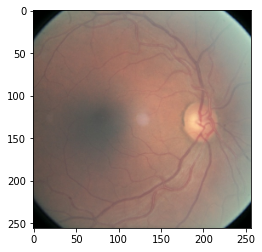

In [23]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
for images_batch, labels_batch in test_ds.take(1):
  #first_image = load_img(r"/content/20221119_143811.jpg", target_size=(IMAGE_SIZE, IMAGE_SIZE))
  #first_image_array = np.array(first_image)  
  first_image=image_batch[0].numpy().astype("uint8")
  print("First image to predict")
  plt.imshow(first_image)
  print("Actual label:",class_names[labels_batch[0].numpy()])
  batch_prediction=model.predict(images_batch)
  print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [24]:
scores=model.evaluate(test_ds)

4/4 [==============================] - 0s 101ms/step - loss: 0.1776 - accuracy: 0.9473


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
model.save("/content/drive/MyDrive/Model.h5")

In [27]:
def predict (model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)
  predictions=model.predict(img_array)
  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)
  return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


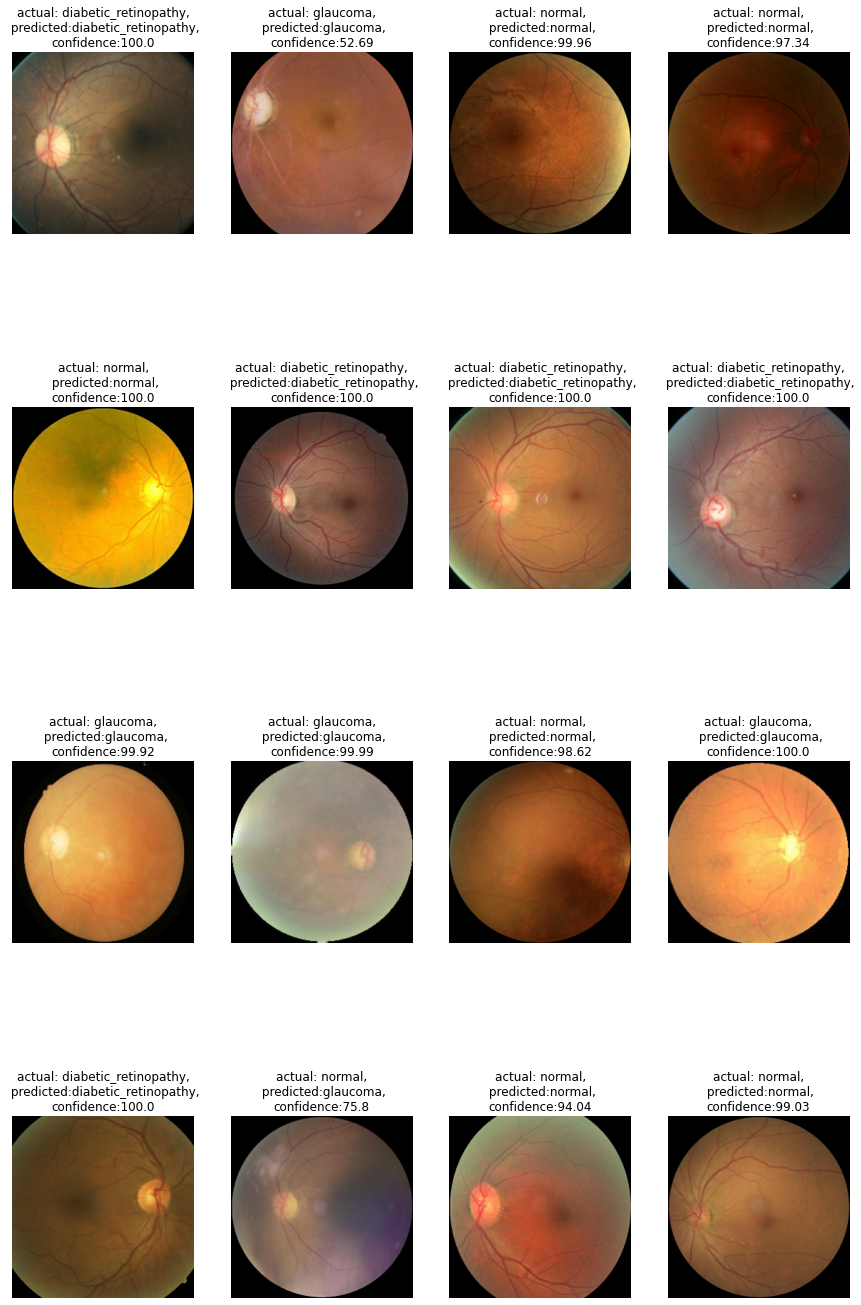

In [28]:
import numpy as np
plt.figure(figsize=(15,25))
for images,labels in test_ds.take(1):
  for i in range(16):
    axisx=plt.subplot(4,4,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    predicted_class, confidence=predict(model,images[i].numpy())
    actual_class=class_names[labels[i]]
    plt.title(f"actual: {actual_class},\n predicted:{predicted_class},\nconfidence:{confidence}")
    plt.axis("off")